In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from hls import HarmonicLombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

In [3]:
search_result = lk.search_lightcurve('KIC 5111207')
lcs = [sr.download() for sr in search_result]

In [4]:
times = [lc.time.value for lc in lcs]
fluxes = [lc.flux.value for lc in lcs]
masks = [~f.mask for f in fluxes]

times = [t[m] for t, m in zip(times, masks)]
fluxes = [f[m] for f, m in zip(fluxes, masks)]

quarters = [float(i)*np.ones_like(t) for (i, t) in enumerate(times)]

times = np.concatenate(times)
fluxes = np.concatenate(fluxes)
quarters = np.concatenate(quarters)

In [5]:
hls = HarmonicLombScargle(times, fluxes, quarters, 3)

In [6]:
fgrid = hls.relative_frequency_grid(0.05)
logls = hls.logl_on_grid(fgrid)

  0%|          | 0/215 [00:00<?, ?it/s]

/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)
100%|██████████| 215/215 [00:02<00:00, 77.95it/s]


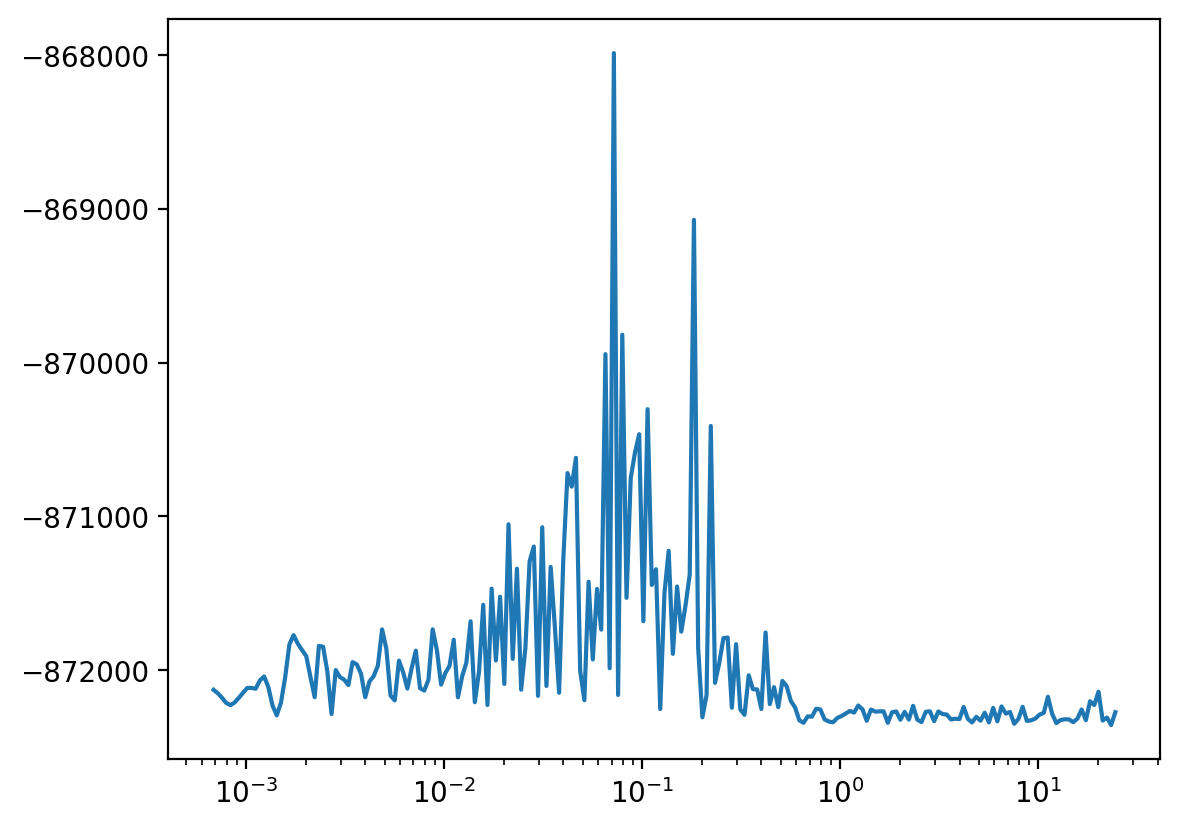

In [7]:
plt.plot(fgrid, logls)
plt.xscale('log')

In [8]:
f_guess = fgrid[np.argmax(logls)]

fgrid_fine = hls.fine_frequency_grid(f_guess, 128)
logls_fine = hls.logl_on_grid(fgrid_fine)

100%|██████████| 128/128 [00:01<00:00, 74.19it/s]


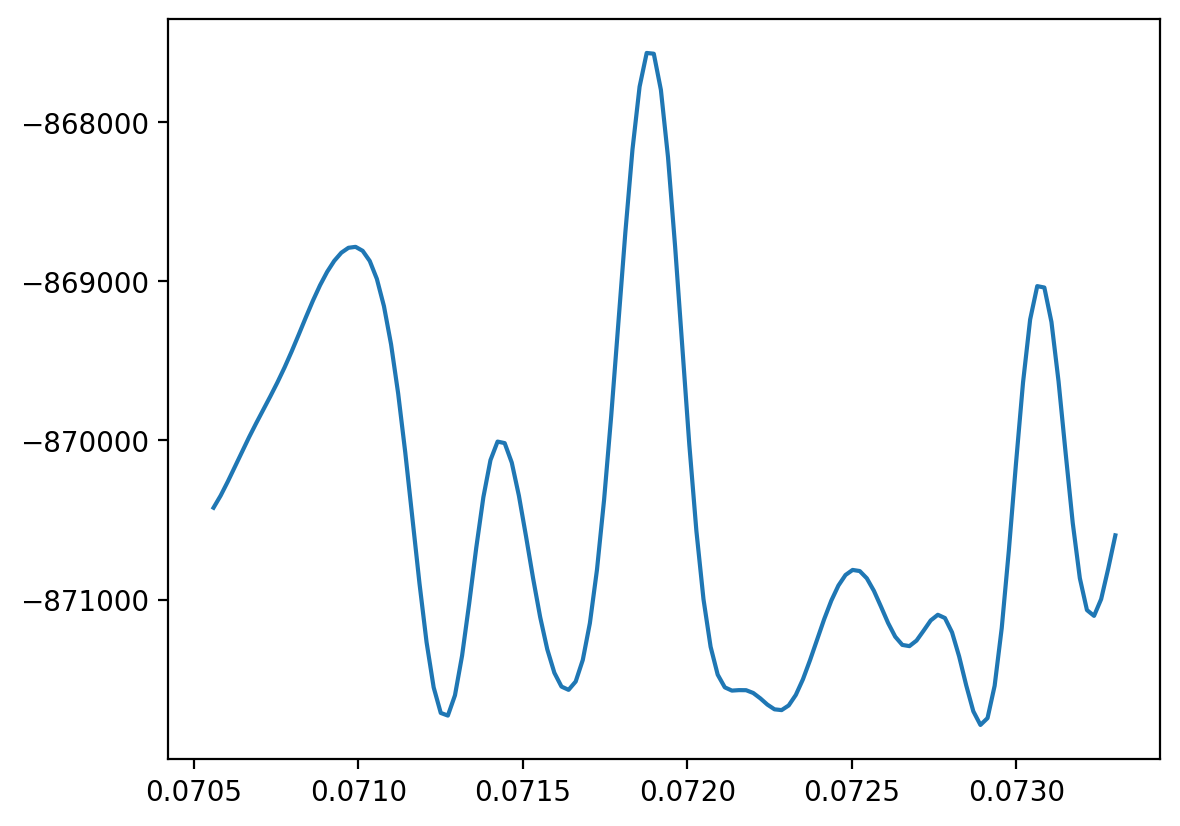

In [9]:
plt.plot(fgrid_fine, logls_fine)

In [11]:
f = hls.interpolated_best_frequency(fgrid_fine, logls_fine)
x_best = hls.best_fit_params(f)

print(f'f_best = {f}/day, or P = {1/f} days')

f_best = 0.07188693293022917/day, or P = 13.910733971229005 days


/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)


Text(0, 0.5, 'Residuals [e- / s]')

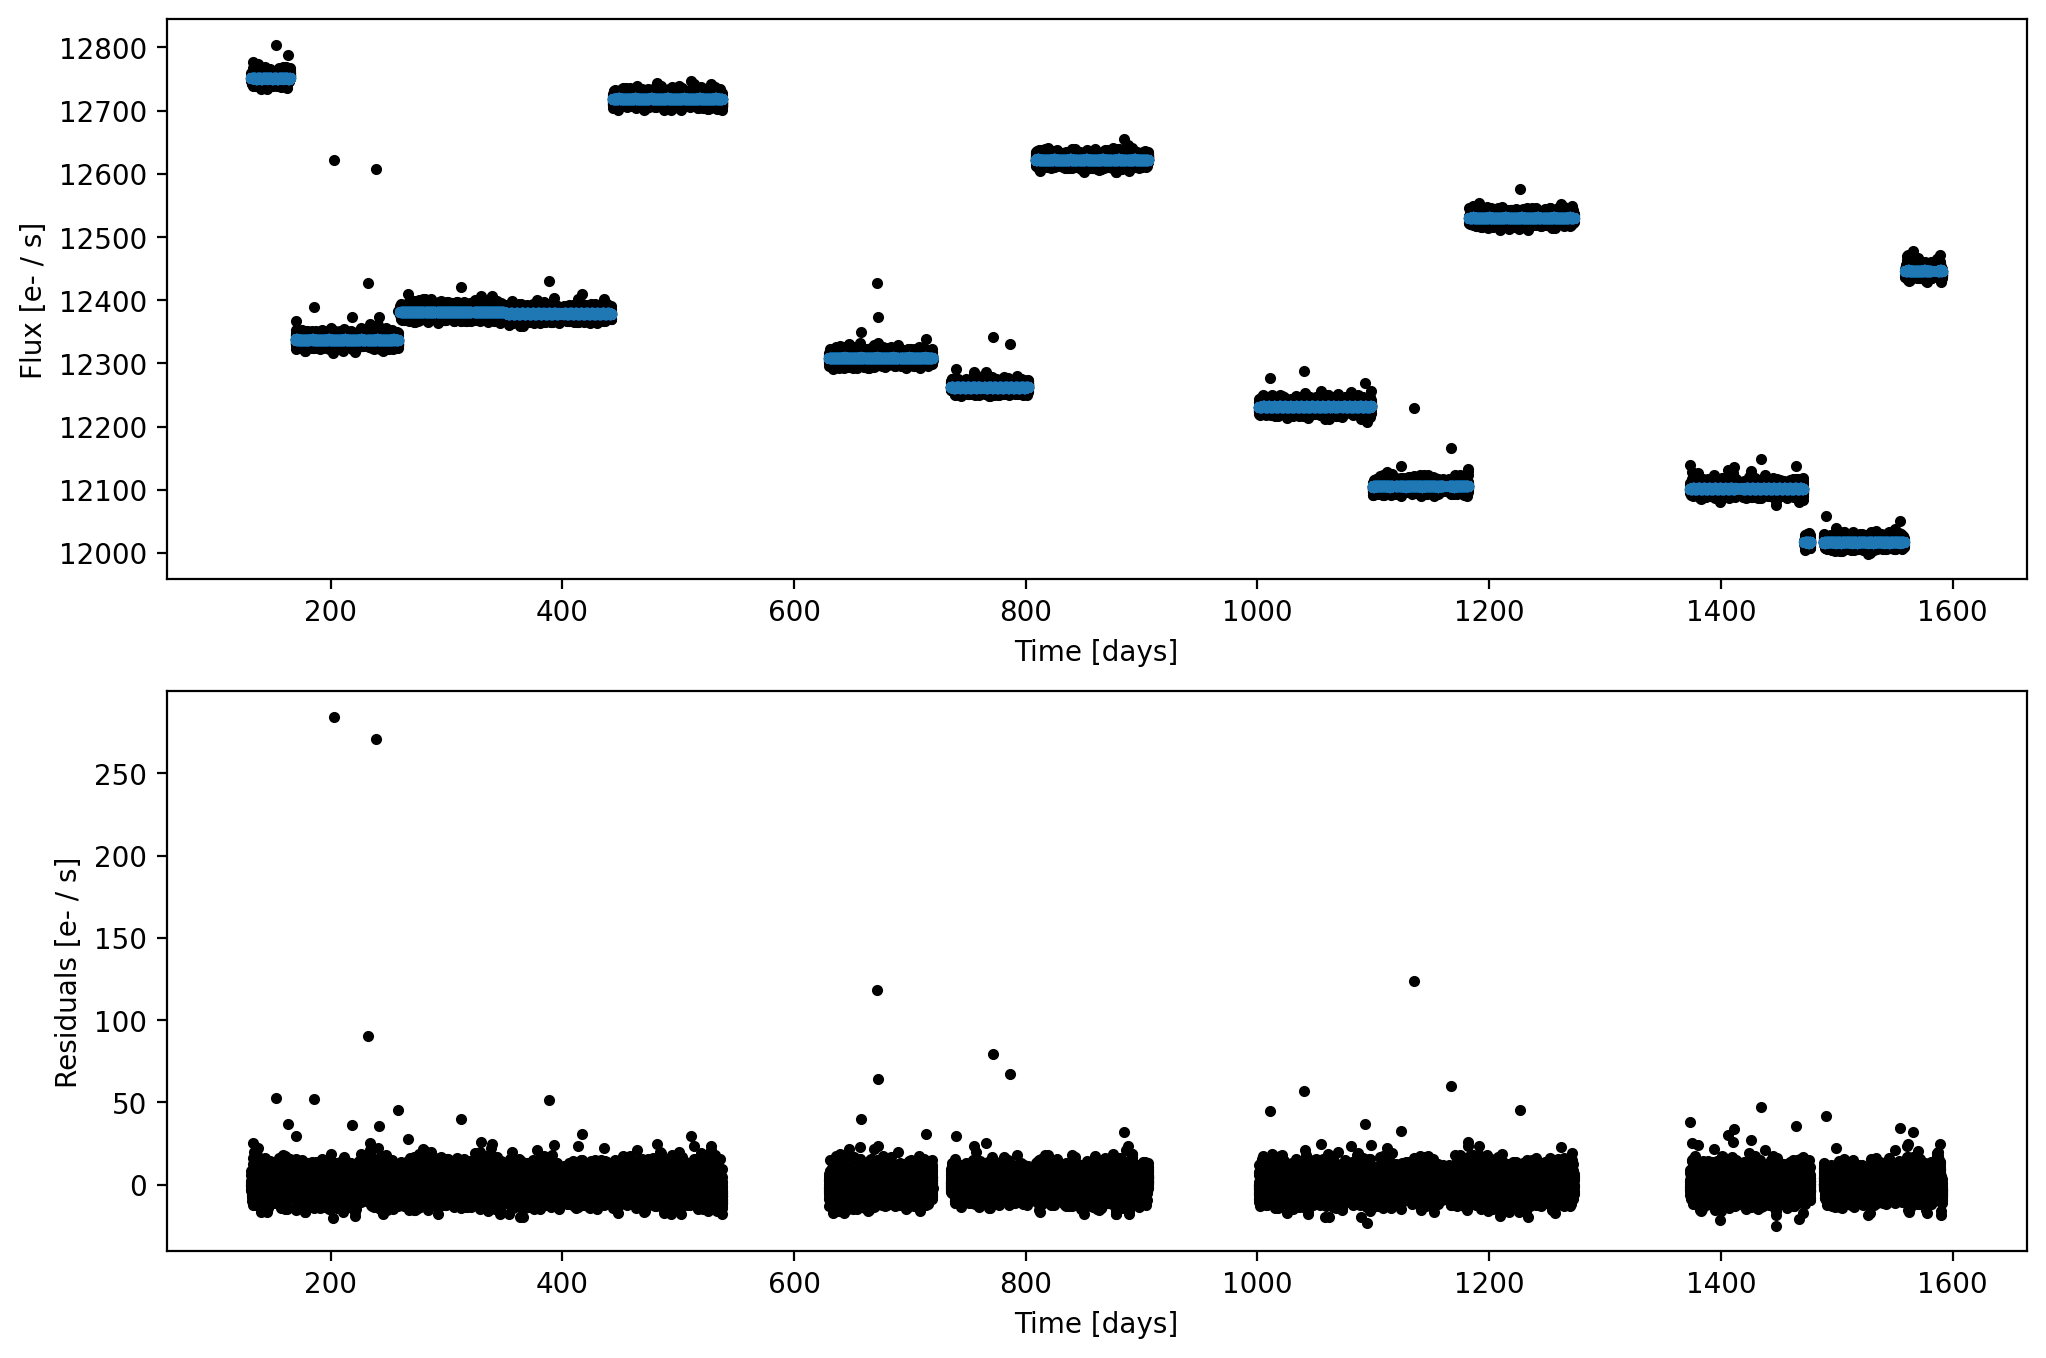

In [12]:
y = hls.predict_flux(f)

fig, subplots = plt.subplots(2, 1, figsize=(12, 8))

subplots[0].plot(times, fluxes, '.k')
subplots[0].plot(times, y, '.')
subplots[0].set_xlabel('Time [days]')
subplots[0].set_ylabel('Flux [e- / s]')

subplots[1].plot(times, fluxes - y, '.k')
subplots[1].set_xlabel('Time [days]')
subplots[1].set_ylabel('Residuals [e- / s]')

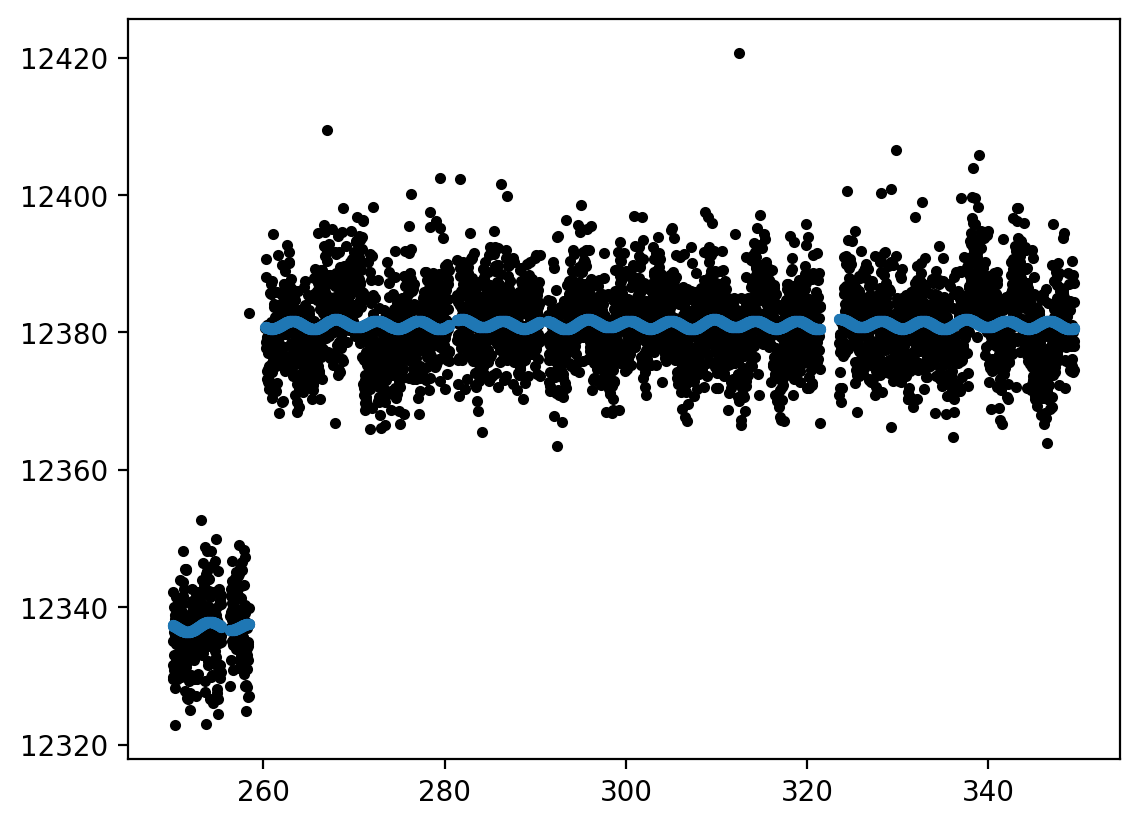

In [13]:
sel = np.abs(times - 300) < 50
plt.plot(times[sel], fluxes[sel], '.k')
plt.plot(times[sel], y[sel], '.')

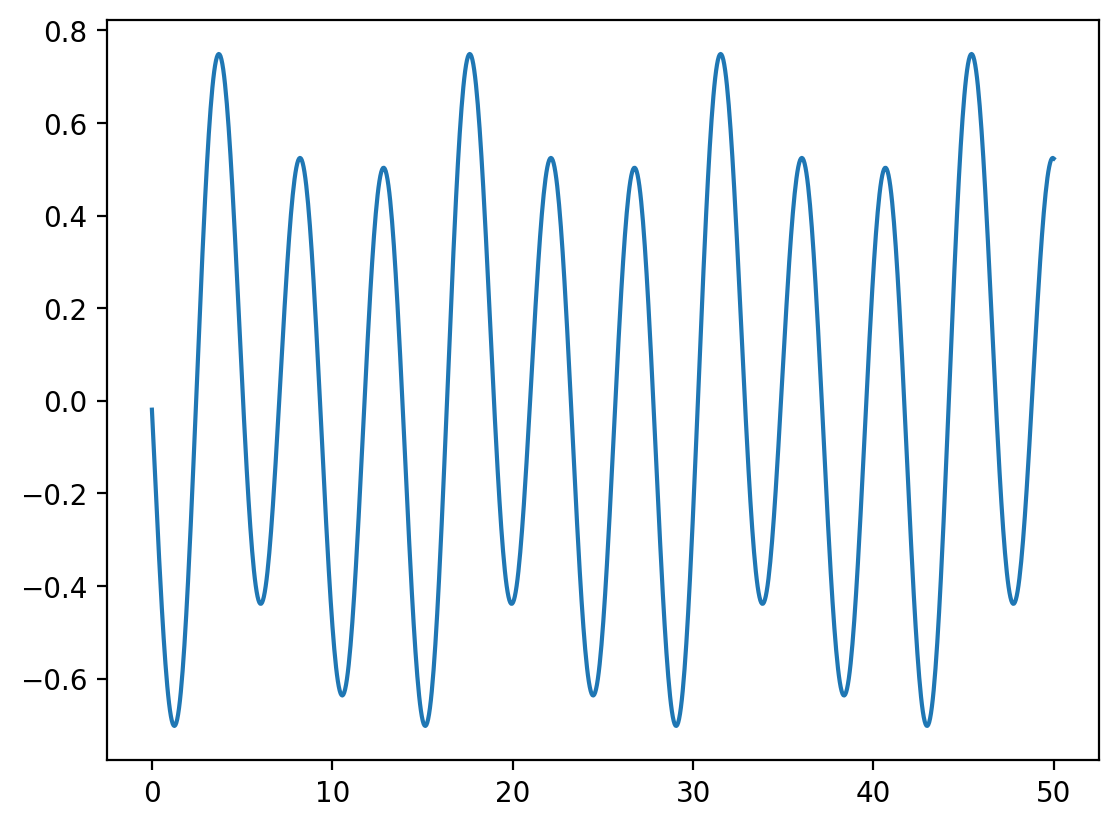

In [14]:
ts = np.linspace(0, 50, 1000)
plt.plot(ts, hls.periodic_lightcurve(ts, f, x_best))